# Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from get_landmarks import get_landmarks
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-05-28 14:38:39.885648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Extraction

In [2]:
!pip freeze

absl-py==2.1.0
altair==5.3.0
annotated-types==0.7.0
anyio==4.3.0
appnope==0.1.4
asttokens==2.4.1
astunparse==1.6.3
attrs==23.2.0
beautifulsoup4==4.12.3
blinker==1.8.2
cachetools==5.3.3
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
distro==1.9.0
easyocr==1.7.1
exceptiongroup==1.2.0
executing==2.0.1
filelock==3.13.4
fire==0.6.0
flatbuffers==24.3.25
fonttools==4.50.0
fsspec==2024.3.1
fugashi==1.3.2
gast==0.4.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.29.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.63.0
h11==0.14.0
h5py==3.11.0
httpcore==1.0.5
httpx==0.27.0
huggingface-hub==0.22.2
idna==3.7
imageio==2.34.0
importlib_metadata==7.1.0
ipykernel==6.29.4
ipython==8.23.0
jaconv==0.3.4
jax==0.4.28
jaxlib==0.4.28
jedi==0.19.1
Jinja2==3.1.3
joblib==1.1.1
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter_client==8.6.1
jupyter_core==5.7.2
keras==2.10.0
Keras-Preproces

In [3]:
path = "clean_data/TEST_TRAIN/"
poses = [os.path.basename(d) for d in glob.glob("clean_data/TEST_TRAIN/*")]

all_imgs_path = []
for pose in poses:
    curr_path = path + pose + "/"
    all_imgs_path += (glob.glob(f"{curr_path}*"))

In [ ]:
# # Do Not Run unless necessary!
# data = []
# for path in tqdm(all_imgs_path, desc="Processing Images..."):
#     landmarks = get_landmarks(cv2.imread(path))
#     landmarks.append(path)
#     data.append(landmarks)

# df = pd.DataFrame(data)

# df.to_csv("raw_kp_data.csv")

In [4]:
df = pd.read_csv("raw_kp_data.csv")
df = df.drop(df.columns[0], axis=1)
columns = []
for lmk in [f"lmk{x}" for x in range(33)]:
    for each in ["x", "y"]:
        columns.append(f"{lmk}_{each}")
columns.append("file_name")

df = df.rename(columns=dict(zip(df.columns, columns)))
df.head(3)

,lmk0_x,lmk0_y,lmk1_x,lmk1_y,lmk2_x,lmk2_y,lmk3_x,lmk3_y,lmk4_x,lmk4_y,...,lmk28_y,lmk29_x,lmk29_y,lmk30_x,lmk30_y,lmk31_x,lmk31_y,lmk32_x,lmk32_y,file_name
0,0.385088,0.702528,0.364045,0.705285,0.361666,0.700772,0.359247,0.696249,0.364545,0.705934,...,0.768468,0.898328,0.851075,0.870051,0.811650,0.781881,0.930616,0.763475,0.904605,clean_data/TEST_TRAIN/downdog/00000372.jpg
1,0.715758,0.547609,0.729912,0.527488,0.729571,0.523913,0.728997,0.520017,0.728891,0.527579,...,0.664694,0.307465,0.655862,0.261937,0.680302,0.380548,0.670513,0.336641,0.713165,clean_data/TEST_TRAIN/downdog/00000414.jpg
2,0.530292,0.608646,0.514618,0.623104,0.510664,0.621608,0.506621,0.619859,0.517501,0.626247,...,0.729783,0.889003,0.781900,0.853871,0.763474,0.806643,0.812826,0.792238,0.797374,clean_data/TEST_TRAIN/downdog/00000158.jpg


In [5]:
# Create df_X and df_y from df

df["pose"] = df["file_name"].apply(lambda x: x.split("/")[2])
df["pose"] = df["pose"].astype("category")
df_X = df.drop(columns=["pose", "file_name"])
df_y = df["pose"]

# Preprocessing Pipeline

1. Drop landmarks 1, 3, 4, 6
2. Scale

In [7]:
# lmk_to_drop = [1, 3, 4, 6]
# cols_to_drop = []
# for lmk in lmk_to_drop:
#     for each in ["x", "y"]:
#         cols_to_drop.append(f"lmk{str(lmk)}_{each}")

# x
cols_to_drop = [2,3,6,7,8,9,12,13]
cols_to_scale = [i for i in range(0,66) if i not in cols_to_drop]

transformers = [
    ("drop", "drop", cols_to_drop),
    ("scale", StandardScaler(), cols_to_scale)
]

column_transformer = ColumnTransformer(transformers=transformers, remainder="passthrough")

pipeline = make_pipeline(
    column_transformer
)

# X = pipeline.fit_transform(np.array(df_X))

# y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_y)
y_ohe = tf.keras.utils.to_categorical(y_encoded)


In [8]:
label_encoder.classes_

array(['downdog', 'goddess', 'plank', 'tree_chest', 'tree_up',
       'warrior2_left', 'warrior2_right'], dtype=object)

### Simple NN

In [9]:
X = pipeline.fit_transform(df_X)
y = y_ohe
y_cat = pd.array(df_y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=[X_train.shape[1]]))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(len(poses), activation="softmax"))

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               7552      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 18,119
Trainable params: 18,119
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_val.shape = }")
print(f"{y_val.shape = }")

X_train.shape = (436, 58)
y_train.shape = (436, 7)
X_val.shape = (110, 58)
y_val.shape = (110, 7)


In [15]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                     verbose=True)

Epoch 1/30
14/14 [==============================] - 1s 20ms/step - loss: 1.4783 - accuracy: 0.4404 - val_loss: 1.0363 - val_accuracy: 0.6364
Epoch 2/30
14/14 [==============================] - 0s 5ms/step - loss: 0.8676 - accuracy: 0.6881 - val_loss: 0.7044 - val_accuracy: 0.7273
Epoch 3/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.8509 - val_loss: 0.4930 - val_accuracy: 0.9545
Epoch 4/30
14/14 [==============================] - 0s 4ms/step - loss: 0.3935 - accuracy: 0.9564 - val_loss: 0.3199 - val_accuracy: 0.9545
Epoch 5/30
14/14 [==============================] - 0s 4ms/step - loss: 0.2378 - accuracy: 0.9702 - val_loss: 0.2349 - val_accuracy: 0.9455
Epoch 6/30
14/14 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.9885 - val_loss: 0.1683 - val_accuracy: 0.9727
Epoch 7/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0968 - accuracy: 0.9908 - val_loss: 0.1382 - val_accuracy: 0.9636
Epoch 8/30
14/14 [

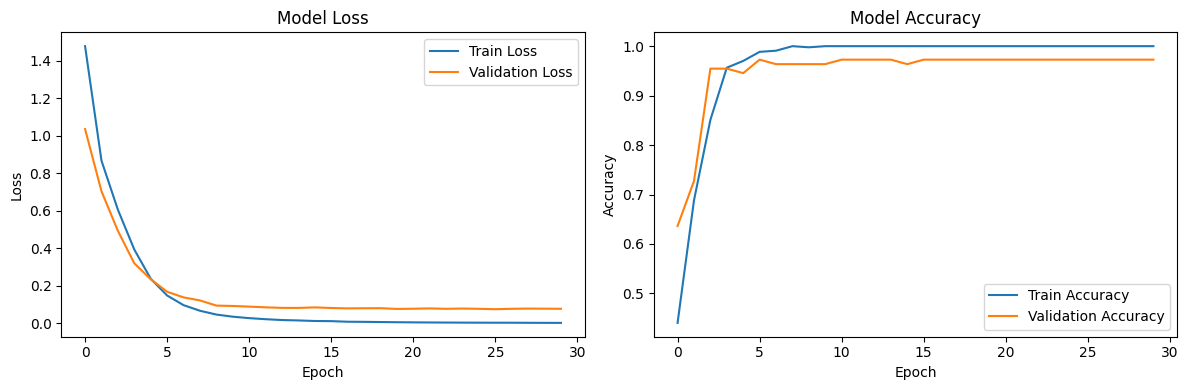

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [17]:
model.save("models/nn_v1.1.h5")
dump(pipeline, "models/pipeline_v1.1.pkl")

['models/pipeline_v1.1.pkl']

In [24]:
pipeline = joblib.load("models/pipeline_v1_1.pkl")

In [26]:
!pwd

/Users/homemasaki/code/projects/yoga-pose-detector-v2
